# 33. Orquestração Multi-Agente em Paralelo (Fan-out/Fan-in)

## Objetivo
Adaptar o fluxo anterior para **Execução Paralela** para reduzir a latência total.

**Fluxo:**
1.  **Início de Processamento**
2.  **Paralelo:**
    *   **Agente Pesquisador**: Busca voos da TAM.
    *   **Agente de Marketing**: Gera campanha para o *Destino* (sem esperar o voo específico).
3.  **Junção (Fan-in):**
    *   **Agente de Precificação**: Recebe o Voo e a Campanha, calcula preço final.

---

In [1]:
%%capture
!pip install -q langgraph langchain langchain-openai pydantic python-dotenv

In [2]:
import random
import os
import operator
from typing import List, Optional, Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from langchain_core.messages import BaseMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END, START
from dotenv import load_dotenv

# Carrega Variáveis
_ = load_dotenv()

## 1. Modelos de Dados (Pydantic)
Mantemos a mesma estrutura, mas a lógica de preenchimento será diferente.

In [3]:
class Voo(BaseModel):
    companhia: str
    numero_voo: str
    origem: str
    destino: str
    horario_saida: str
    custo_operacional: float

class CampanhaMarketing(BaseModel):
    slogan: str = Field(description="Slogan criativo")
    descricao_visual: str = Field(description="Descrição da imagem")
    publico_alvo: str = Field(description="Público alvo")
    custo_marketing: float = Field(description="Custo fixo")

class PacoteFinal(BaseModel):
    voo: Voo
    campanha: CampanhaMarketing
    custo_total: float
    margem_lucro: float
    preco_venda: float

## 2. Estado do Grafo
No LangGraph, para suportar execução paralela onde múltiplos nós escrevem no estado ao mesmo tempo, as chaves não devem ser sobrescritas de forma conflitante. Como `Pesquisador` escreve `voo_selecionado` e `Marketing` escreve `campanha`, **não há conflito**, pois são chaves diferentes. O LangGraph gerencia o merge automaticamente para TypedDicts simples.

In [4]:
class AgentState(TypedDict):
    # Inputs
    origem: str
    destino: str
    
    # Outputs independentes (podem ser gerados em paralelo)
    voo_selecionado: Optional[Voo]
    campanha: Optional[CampanhaMarketing]
    
    # Output Final
    pacote_final: Optional[PacoteFinal]

## 3. Agentes Adaptados

### Agente Pesquisador
(Igual ao anterior)

In [5]:
def agente_pesquisador_voos(state: AgentState):
    print("\n[Agente Pesquisador] Iniciando busca paralela...")
    origem = state['origem']
    destino = state['destino']
    
    # Mock data
    custo = random.uniform(800, 1200)
    voo = Voo(
        companhia="TAM",
        numero_voo=f"JJ{random.randint(1000, 9999)}",
        origem=origem,
        destino=destino,
        horario_saida="14:00",
        custo_operacional=custo
    )
    print(f"[Agente Pesquisador] Voo encontrado: {voo.numero_voo}")
    return {"voo_selecionado": voo}

### Agente Marketing (Adaptado para Paralelismo)
Como ele roda **ao mesmo tempo** que o pesquisador, ele **não sabe** qual voo foi escolhido (número do voo, horário). 
Ele foca no **Destino** e na Marcas Genérica.

In [6]:
def agente_marketing(state: AgentState):
    print("\n[Agente Marketing] Criando campanha em paralelo...")
    destino = state['destino']
    
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.7)
    
    prompt = ChatPromptTemplate.from_template(
        "Crie uma campanha turística para {destino}. A companhia aérea é TAM. "
        "Público: {publico}. Custo Fixo Mkt: 150.00."
    )
    
    chain = prompt | llm.with_structured_output(CampanhaMarketing)
    
    campanha = chain.invoke({
        "destino": destino,
        "publico": "geral"
    })
    
    # Fixar custo para cálculo exato no próximo passo
    campanha.custo_marketing = 150.00
    
    print(f"[Agente Marketing] Campanha pronta para: {destino}")
    return {"campanha": campanha}

### Agente Precificação (Fan-In)
Este agente precisa esperar **ambos** terminarem. O LangGraph garante isso se ele for o nó destino de ambas as arestas.

In [7]:
def agente_precificacao(state: AgentState):
    print("\n[Agente Precificação] Consolidando dados...")
    
    # Aqui o state já deve ter as duas chaves preenchidas
    voo = state.get('voo_selecionado')
    campanha = state.get('campanha')
    
    if not voo or not campanha:
        raise ValueError("Erro: Faltam dados do voo ou da campanha!")
    
    custo_total = voo.custo_operacional + campanha.custo_marketing
    lucro = custo_total * 0.10
    preco_final = custo_total + lucro
    
    pacote = PacoteFinal(
        voo=voo,
        campanha=campanha,
        custo_total=custo_total,
        margem_lucro=lucro,
        preco_venda=preco_final
    )
    
    return {"pacote_final": pacote}

## 4. Definindo o Grafo Paralelo
Conectamos o `START` para ambos (`Pesquisador` e `Marketing`). E ambos conectam para `Precificação`.

In [8]:
workflow = StateGraph(AgentState)

workflow.add_node("Pesquisador", agente_pesquisador_voos)
workflow.add_node("Marketing", agente_marketing)
workflow.add_node("Precificacao", agente_precificacao)

# Fan-out: Do início para os dois ao mesmo tempo
workflow.add_edge(START, "Pesquisador")
workflow.add_edge(START, "Marketing")

# Fan-in: Ambos vão para Precificação
workflow.add_edge("Pesquisador", "Precificacao")
workflow.add_edge("Marketing", "Precificacao")

# Finaliza
workflow.add_edge("Precificacao", END)

app = workflow.compile()

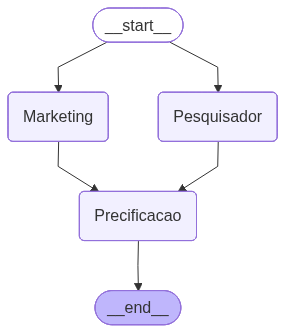

In [9]:
# Visualização do Grafo
try:
    from IPython.display import Image
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass

## 5. Execução

In [10]:
inputs = {
    "origem": "Rio de Janeiro (GIG)",
    "destino": "Nova York (JFK)"
}

result = app.invoke(inputs)

print("\n================ RESULTADO PARALELO ================")
pkg = result['pacote_final']
print(f"Voo: {pkg.voo.numero_voo} | Custo Op: {pkg.voo.custo_operacional:.2f}")
print(f"Marketing: {pkg.campanha.slogan}")
print(f"Preço Final: R$ {pkg.preco_venda:.2f}")


[Agente Marketing] Criando campanha em paralelo...

[Agente Pesquisador] Iniciando busca paralela...
[Agente Pesquisador] Voo encontrado: JJ8077


[Agente Marketing] Campanha pronta para: Nova York (JFK)

[Agente Precificação] Consolidando dados...

================ RESULTADO PARALELO ================
Voo: JJ8077 | Custo Op: 830.37
Marketing: Nova York te espera: Voe com a TAM!
Preço Final: R$ 1078.41
